In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv
from SimPEG import maps
from SimPEG.electromagnetics import time_domain as TDEM

In [2]:
eps = 1e-6
# I used provided start and end times for first pulse to accurately create the correctly sized square-waveform
ramp_on = np.r_[0.007, 0.007 + eps]
ramp_off = np.r_[0.020-eps, 0.020]
# waveform = TDEM.sources.TrapezoidWaveform(
#     ramp_on=ramp_on, ramp_off=ramp_off
# )

In [3]:
times_currents = np.r_[ramp_on, ramp_off]
times_currents -= times_currents.max()
currents = np.array([0,1,1,0])
waveform = TDEM.sources.PiecewiseLinearWaveform(times_currents, currents)

In [4]:
# seems the on-time 
print (f"on-time length={np.round((times_currents.max()-times_currents.min()) * 1e3)}ms")

on-time length=13.0ms


In [5]:
# waveform_times = np.r_[np.linspace(0, 1 ,1000)]

# fig = plt.figure(figsize=(8, 6))
# ax = fig.add_axes([0.1, 0.1, 0.85, 0.8])

# plotting_current = [waveform.eval(t) for t in waveform_times]
# ax.plot(waveform_times, plotting_current, "r", lw=2)
# ax.set_xlim(-0.01,0.03)

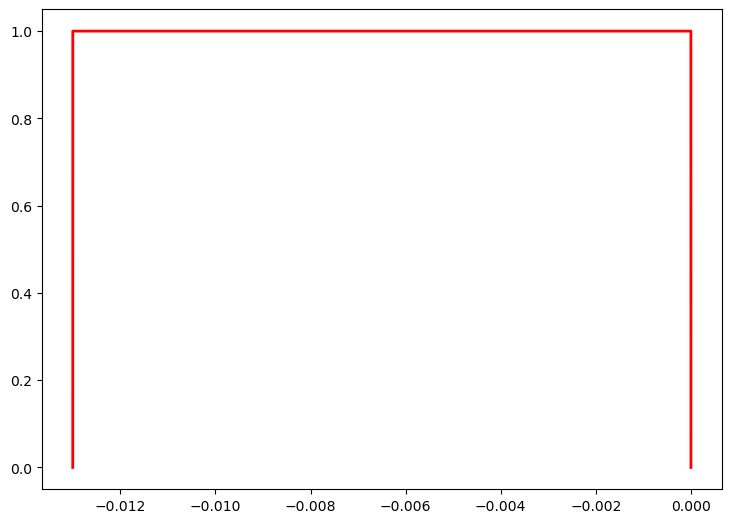

In [6]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_axes([0.1, 0.1, 0.85, 0.8])

ax.plot(times_currents, currents, "r", lw=2)
# ax.set_xlim(-0.01,0.03)

In [7]:
def import_file(file):
    with open(file, 'r') as f:
        reader = csv.reader(f)
        data = list(reader)
    line = np.array(data, dtype=float)
    cond = line[:,25:55]
    thicknesses = line[0,55:84]
    print(len(thicknesses))
    depths = line[0,115:145]
    log_cond_uncertainty = line[:,237:267]
    obs_zs = line[:,286:301]
    obs_zs_noise = line[:,316:331]
    print(obs_zs.shape)
    pred_zs = line[:,348:363]
    print(pred_zs.shape)
    return cond, thicknesses, depths, log_cond_uncertainty, obs_zs, obs_zs_noise, pred_zs

In [8]:
conductivities, thicknesses, depths, log_cond_uncert, obs_zs, obs_zs_noise, pred_zs = import_file('Line1_Central-Copy1.csv')

29
(16258, 15)
(16258, 15)


In [10]:
source_location=np.array([0, 0, 120])

In [11]:
receiver_location=np.array([[-108,0, 68]])

In [12]:
# Define conductivities - I have tried using both the raw conductivies, as well as the conductivities with uncertainty included
cond_raw = conductivities[1]
# print(cond_raw)
cond_uncert = 10**log_cond_uncert[1]
# print(cond_uncert)
cond = cond_raw+cond_uncert


# These are the times listed for the center of each pulse - I also have the start and end times for each pulse
times = np.array([0.013, 0.039, 0.065, 0.104, 0.169, 0.273, 0.443, 0.703, 1.094, 
                          1.693, 2.63, 4.102, 6.406, 9.961, 16.055]) * 1e-3  # Time channels (s)


# Receiver is 52m below transmitter and 108m behind it on the X-axis
receiver_location = np.array([[-108,0, 68]])  # Receiver location
receiver = TDEM.receivers.PointMagneticFluxTimeDerivative(
    locations=receiver_location, times=times, orientation="z", 
    # use_source_receiver_offset=True
)

receiver_b = TDEM.receivers.PointMagneticFluxDensity(
    locations=receiver_location, times=times, orientation="z", 
    # use_source_receiver_offset=True
)


# Transmitter area was listed as 155m^2 and the moment is listed as 43400 Am^2
source_location = np.array([0, 0, 120])  # Source location
source = TDEM.sources.MagDipole(
    receiver_list=[receiver, receiver_b],
    waveform=waveform,
    location=source_location,
    # radius = 7,  # Transmitter loop radius
    moment = 1, # usually the data are normalized by the Tx moment. 
    srcType = 'inductive'
)

# Define the survey
survey = TDEM.Survey([source])

# Create a mapping for the conductivity model
sigma_map = maps.IdentityMap(nP=30)

# Set up the simulation
simulation = TDEM.Simulation1DLayered(
    survey=survey,
    thicknesses=thicknesses,  # Layer thicknesses
    sigmaMap=sigma_map,       # Conductivity mapping
)

# Forward model: Compute data
data = simulation.dpred(cond_raw)  # Pass the conductivities as the model

# I also attempted to use receiver.PointMagnectiveFluxDensity and manually calculate dB/dt - results did not change
# data_dBdt = np.gradient(data, times)

# Given observed data in fT
obs_B_fT = obs_zs[1]

obs_noise = obs_zs_noise[1]

pred_B_fT = pred_zs[1]

# Incorporating observed noise makes minimal difference
# obs_B_fT = obs_B_fT - obs_noise

# Convert observed B field from fT to T
obs_B_T = obs_B_fT * 1e-15  # Convert fT to T
# print(obs_B_T)

pred_B_T = pred_B_fT * 1e-15
# print(pred_B_T)

# Calculate derivative since provided values are B-fields
obs_dBdt = np.gradient(obs_B_T, times)

pred_dBdt = np.gradient(pred_B_T, times)

# scaling_factor = 1.5
# obs_scaling = 0.7

# data_dBdt = np.abs(data_dBdt)**scaling_factor
# obs_dBdt = obs_dBdt**obs_scaling

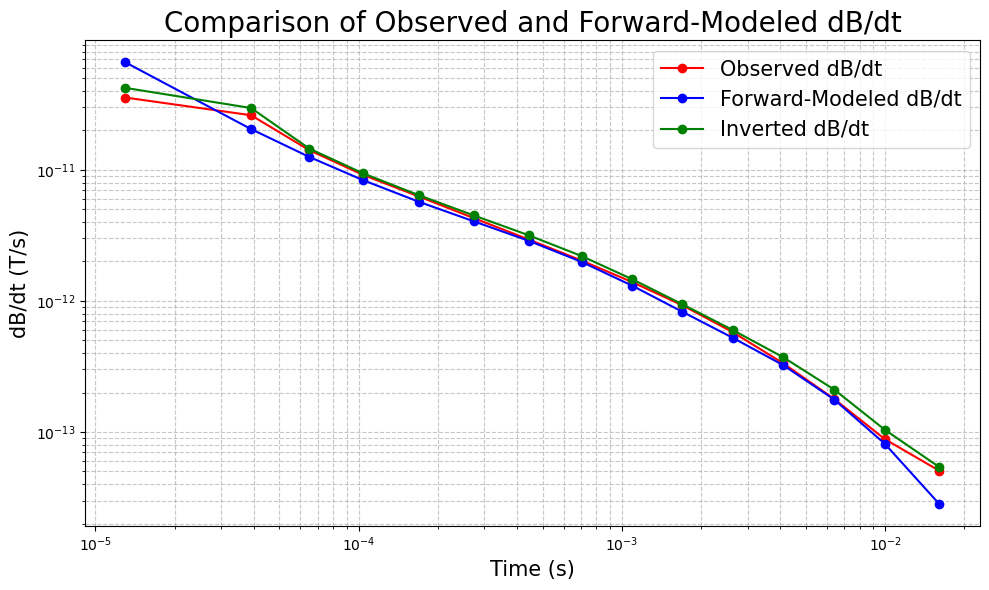

In [27]:
# Plot observed vs. forward-modeled dB/dt
plt.figure(figsize=(10, 6))
plt.loglog(times, np.abs(obs_dBdt), 'ro-', label="Observed dB/dt")
plt.loglog(times, np.abs(data[:len(times)]), 'bo-', label="Forward-Modeled dB/dt")
plt.loglog(times, np.abs(pred_dBdt), 'go-', label='Inverted dB/dt')
plt.xlabel("Time (s)", fontsize = 15)
plt.ylabel("dB/dt (T/s)",fontsize = 15)
plt.title("Comparison of Observed and Forward-Modeled dB/dt",fontsize = 20)
plt.legend(fontsize = 15)
plt.tight_layout()
plt.grid(True, which="both", linestyle="--", alpha=0.7)
plt.show()


In [28]:
obs_zs.shape

(16258, 15)

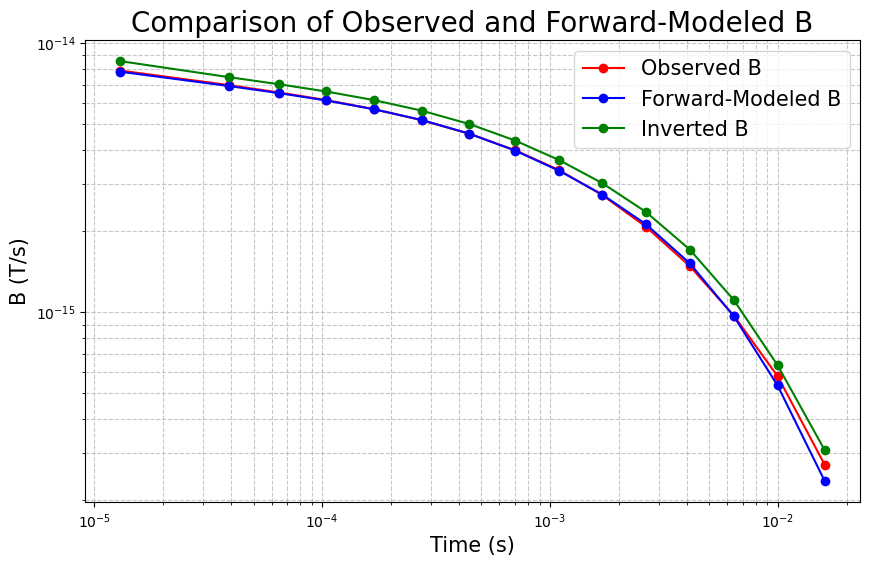

In [29]:
# Plot observed vs. forward-modeled B
plt.figure(figsize=(10, 6))
plt.loglog(times, np.abs(obs_B_fT)*1e-15, 'ro-', label="Observed B")
plt.loglog(times, np.abs(data[len(times):]), 'bo-', label="Forward-Modeled B")
plt.loglog(times, np.abs(pred_B_fT)*1e-15, 'go-', label='Inverted B')
plt.xlabel("Time (s)", fontsize = 15)
plt.ylabel("B (T/s)", fontsize=15)
plt.title("Comparison of Observed and Forward-Modeled B", fontsize=20)
plt.legend(fontsize = 15)
plt.grid(True, which="both", linestyle="--", alpha=0.7)
plt.show()
